In [ ]:
import re
import numpy as np 
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D,GRU ,Flatten
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
#file reader
TrainData = pd.read_csv('/content/TrainData.csv')
TrainGT=pd.read_csv('/content/TrainGT.csv')
ValidationData=pd.read_csv('/content/ValidationData.csv')
ValidationGT=pd.read_csv('/content/ValidationGT.csv')
TestData=pd.read_csv('/content/TestData.csv')

In [ ]:
#preprocessing text
def preprocess_text(sen):
    sen['text'] = sen['text'].apply(lambda x: x.lower())
    sen['text'] = sen['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
    sen['ID']=sen['ID']
    return sen

sen_TrainData = preprocess_text(TrainData)
##sen_TrainData=sen_TrainData[0:500]
sen_ValidationData=preprocess_text(ValidationData)
#sen_ValidationData=sen_ValidationData[0:50]
sen_ID=preprocess_text(TrainData)
sen_val_ID=preprocess_text(ValidationData)
sen_test_data=preprocess_text(TestData)

In [ ]:
def tokeniz(max_fature,sen):
    global X , max_fatures,k,tokenizer
    max_fatures = max_fature
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(sen['text'].values )
    X = tokenizer.texts_to_sequences(sen['text'].values)
    X= pad_sequences(X)
    return X
X_TrainData=tokeniz(2000,sen_TrainData)
X_ValidationData=tokeniz(2000,sen_ValidationData)
#X_ValidationData=X_ValidationData[0:50]
X_TestData=tokeniz(2000,sen_test_data)

In [ ]:
def sentiment(data_GT,x_data):
    data_GT=data_GT[['sentiment']]
    data_GT = data_GT[data_GT['sentiment'] != "Neutral"]
    label_data = pd.get_dummies(data_GT[0:len(x_data)]['sentiment']).values
    print('Size : ',data_GT[ data_GT['sentiment'] == 1].size)
    print('Size : ',data_GT[ data_GT['sentiment'] == 0].size)
    return label_data
Y_TrainData= sentiment(TrainGT,X_TrainData)
Y_ValidationData=sentiment(ValidationGT,X_ValidationData)

Size :  19981
Size :  20019
Size :  2514
Size :  2486


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_TrainData,Y_TrainData, test_size = 0.33, random_state = 42)
X_ValData,X_testValData, Y_ValData,Y_testValData = train_test_split(X_ValidationData,Y_ValidationData, random_state = 42)
#print(Y_test)
#print (X_test)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26800, 1871) (26800, 2)
(13200, 1871) (13200, 2)


In [ ]:
embed_dim = 128
model = Sequential()
X_TrainData=tokeniz(2000,sen_TrainData)
model.add(Embedding(max_fatures, embed_dim,input_length = X_TrainData.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(GRU(units=32))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1871, 128)         256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1871, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, 32)                15552     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 271,618
Trainable params: 271,618
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 128
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=7, verbose=2 ,validation_split=0.2,validation_data=(X_test,Y_test))
score = model.evaluate(X_test, Y_test, verbose=2)
print("Test Score:" ,score[0])
print("Test Accuracy:" , score[1])

Epoch 1/7
168/168 - 269s - loss: 0.1485 - accuracy: 0.9440 - val_loss: 0.4538 - val_accuracy: 0.8571
Epoch 2/7
168/168 - 270s - loss: 0.1402 - accuracy: 0.9482 - val_loss: 0.4338 - val_accuracy: 0.8569
Epoch 3/7
168/168 - 269s - loss: 0.1390 - accuracy: 0.9489 - val_loss: 0.4388 - val_accuracy: 0.8604
Epoch 4/7
168/168 - 268s - loss: 0.1306 - accuracy: 0.9535 - val_loss: 0.4548 - val_accuracy: 0.8582
Epoch 5/7
168/168 - 269s - loss: 0.1240 - accuracy: 0.9552 - val_loss: 0.4772 - val_accuracy: 0.8621
Epoch 6/7
168/168 - 270s - loss: 0.1206 - accuracy: 0.9571 - val_loss: 0.4989 - val_accuracy: 0.8530
Epoch 7/7
168/168 - 270s - loss: 0.1110 - accuracy: 0.9604 - val_loss: 0.4798 - val_accuracy: 0.8599
413/413 - 52s - loss: 0.4601 - accuracy: 0.8570
Test Score: 0.460128515958786
Test Accuracy: 0.8570454716682434


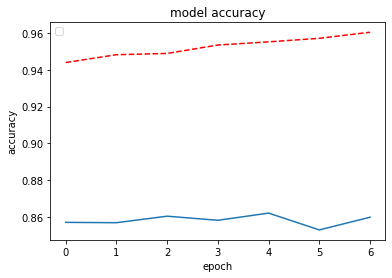

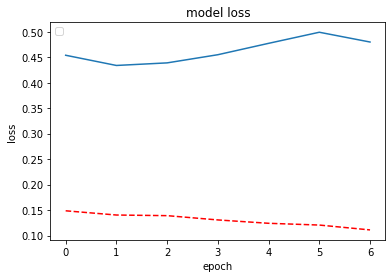

In [ ]:
#plot
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['accuracy'],'r--')
plt.plot(history.history['val_accuracy'])
plt.show()



plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['loss'],'r--')
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
result=model.predict_classes(X_TestData)
print(result)


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1 0 0 ... 0 0 1]


In [ ]:
df= open("pri.csv", "w")
df=pd.DataFrame(data=list(zip(TestData['ID'],result)),columns=['ID','label'])
pred_Data=df.to_csv('pri.csv',',',index=False)